# mapping-challenge-mask_rcnn-prediction-submission
![CrowdAI-Logo](https://github.com/crowdAI/crowdai/raw/master/app/assets/images/misc/crowdai-logo-smile.svg?sanitize=true)

This notebook contains the code for making predictions from the model trained in [Training.ipynb](Training.ipynb) (or by using the [released pretrained model](https://www.crowdai.org/challenges/mapping-challenge/dataset_files)) for the [crowdAI Mapping Challenge](https://www.crowdai.org/challenges/mapping-challenge).

This code is adapted from the [Mask RCNN]() tensorflow implementation available here : [https://github.com/matterport/Mask_RCNN](https://github.com/matterport/Mask_RCNN).

First we begin by importing all the necessary dependencies : 

In [3]:
import os
import sys
import time
import numpy as np
import skimage.io
import random
import math
import re
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download and install the Python COCO tools from https://github.com/waleedka/coco
# That's a fork from the original https://github.com/pdollar/coco with a bug
# fix for Python 3.
# I submitted a pull request https://github.com/cocodataset/cocoapi/pull/50
# If the PR is merged then use the original repo.
# Note: Edit PythonAPI/Makefile and replace "python" with "python3".
#  
# A quick one liner to install the library 
# !pip install git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

import coco #a slightly modified version

from mrcnn.evaluate import build_coco_results, evaluate_coco
from mrcnn.dataset import MappingChallengeDataset
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

import zipfile
import urllib.request
import shutil
import glob
import tqdm
import random
import json
import argparse
import base64

Using TensorFlow backend.


## Dataset location 
Now we expect that you have downloaded all the files in the datasets section and untar-ed them to have the following structure :
```
├── data
|   ├── pretrained_weights.h5 (already included in this repository)
│   ├── test
│   │   └── images/
│   │   └── annotation.json
│   ├── train
│   │   └── images/
│   │   └── annotation.json
│   └── val
│       └── images/
│       └── annotation.json
```

In [4]:
ROOT_DIR = os.getcwd()

%matplotlib inline 

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR, "data/" "pretrained_weights.h5")
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = "/data/data/crowdai/val/images"
print(IMAGE_DIR)

/data/data/crowdai/val/images


In [5]:
data_directory = "data/"
annotation_file_template = "{}/{}/annotation{}.json"

TRAIN_IMAGES_DIRECTORY = "data/train/images"
TRAIN_ANNOTATIONS_PATH = "/data/data/crowdai/train/annotation-small.json"
TRAIN_ANNOTATIONS_SMALL_PATH = "/data/data/crowdai/train/annotation-small.json"

VAL_IMAGES_DIRECTORY = "data/val/images"
VAL_ANNOTATIONS_PATH = "data/val/annotation.json"
VAL_ANNOTATIONS_SMALL_PATH = "/data/data/crowdai/val/annotation-small.json"

# Instantitate Inference Config

In [6]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # 1 Background + 1 Building
    IMAGE_MAX_DIM=320
    IMAGE_MIN_DIM=320
    NAME = "crowdai-mapping-challenge"
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           crowdai-mapping-challenge
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

# Instantiate Model

In [ ]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model_path = model.find_last()[1]

# or if you want to use the latest trained model, you can use : 
# model_path = model.find_last()[1]

model.load_weights(model_path, by_name=True)

In [6]:
# Load validation dataset
dataset_val = MappingChallengeDataset()
val_coco = dataset_val.load_dataset(dataset_dir=os.path.join("/data/data/crowdai", "val"), load_small=True, return_coco=True)
dataset_val.prepare()

Annotation Path  /data/data/crowdai/val/annotation-small.json
Image Dir  /data/data/crowdai/val/images
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [2]:
image_id = dataset_val.image_ids[0]
image = dataset_val.load_image(image_id)
mask, class_ids = dataset_val.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

print("image_id ", image_id, dataset_val.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
visualize.display_instances(image, bbox, mask, class_ids)

NameError: name 'dataset_val' is not defined

In [8]:
def get_ax(rows=1, cols=1, size=7):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


image ID: crowdai-mapping-challenge.20289 (0) crowdai-mapping-challenge::0
Processing 1 images
image                    shape: (320, 320, 3)         min:   20.00000  max:  254.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -103.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


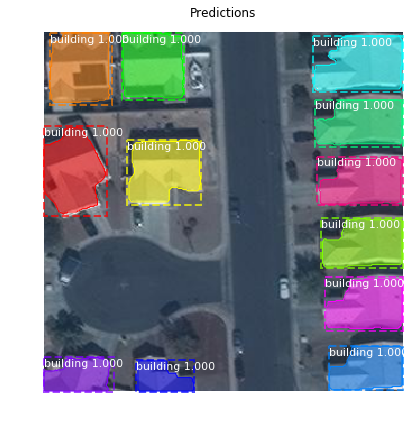

gt_class_id              shape: (13,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (13, 4)               min:    0.00000  max:  320.00000  int32
gt_mask                  shape: (320, 320, 13)        min:    0.00000  max:    1.00000  uint8


In [9]:
image_id = dataset_val.image_ids[0]
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


## Augmentation

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import sys
sys.path.append('ROOT_DIR')

In [12]:
import cv2 
import numpy as np
from deeplab import vis_segmentation
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from six.moves import urllib
from utils import color_map,multi_iou
%matplotlib inline

In [13]:
FILE = 20289
IN_SIZE = 300

image ID: crowdai-mapping-challenge.20289 (0) crowdai-mapping-challenge::0
Processing 1 images
image                    shape: (320, 320, 3)         min:   20.00000  max:  254.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -103.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


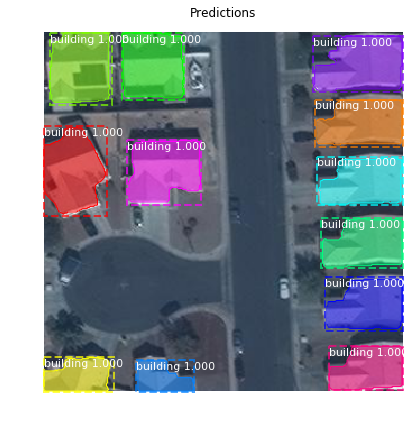

gt_class_id              shape: (13,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (13, 4)               min:    0.00000  max:  320.00000  int32
gt_mask                  shape: (320, 320, 13)        min:    0.00000  max:    1.00000  uint8


In [14]:
image_id = dataset_val.image_ids[0]
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))
# Run object detection
without_aug = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = without_aug[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [26]:
from edafa import SegPredictor

In [27]:
class myPredictor(SegPredictor):
    def __init__(self,model,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.model = model

    def predict_patches(self,patches):
        res = []
        for i in range(patches.shape[0]):
            seg_map=self.model.detect(patches[i,...])
            res.append(seg_map[np.newaxis,:,:,np.newaxis])
        return np.concatenate(res,axis=0)

In [28]:
conf = '{ \
            "augs": ["NO", "FLIP_LR","BRIGHT"],\
            "mean":"ARITH",\
            "bits":8\
        }'

In [29]:
p = myPredictor(model,IN_SIZE,1,conf)

In [34]:
with_aug = p.predict_images([image],overlap=0)
# with_aug = postprocess(with_aug,pad_x)

AssertionError: len(images) must be equal to BATCH_SIZE

In [33]:
# Visualize the output 
vis_segmentation(image, with_aug.astype(np.uint8))

NameError: name 'with_aug' is not defined

In [32]:
#print('IoU with no augmentation: %.6f'%multi_iou(new_gt,without_aug))
print('IoU with augmentation: %.6f'%multi_iou(new_gt,with_aug))

NameError: name 'new_gt' is not defined

### Segemtation with keras

In [ ]:
from edafa import SegPredictor

In [ ]:
class myPredictor(SegPredictor):
    def __init__(self,model,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.model = model

    def predict_patches(self,patches):
        results = list()
        for patch in patches:
            pad_x, normalized = normalize(patch)
            res = self.model.detect(normalized)
            r = np.asarray(res[0]['masks']).astype(np.uint8)
            results.append(r[:,:,0:1])
        
        return np.asarray(results).astype(np.uint8)

In [ ]:
p = myPredictor(model,IN_SIZE,2, 'sample.json')

In [ ]:
def normalize(img):
    img = img[:,:,[2,1,0]]
    w, h, _ = img.shape
    ratio = IN_SIZE / np.max([w,h])
    resized = cv2.resize(img,(int(ratio*h),int(ratio*w)))
    resized = resized / 127.5 - 1.
    pad_x = int(IN_SIZE - resized.shape[0])
    resized2 = np.pad(resized,((0,pad_x),(0,0),(0,0)),mode='constant')
    return pad_x,np.expand_dims(resized2,0)

In [ ]:
def postprocess(pred,pad_x):
    labels = np.argmax(pred.squeeze(),-1)
    return (labels[:-pad_x])

In [ ]:
pad_x,normalized = normalize(img)
res = model.detect(normalized)
r = np.asarray(res[0]['masks']).astype(np.uint8)
no_aug = postprocess(r,pad_x)
plt.imshow(r[:,:,0])

In [ ]:
with_aug = p.predict_images([normalized],overlap=0)